In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.engine import engine, connectivity

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the transport network.
## Saves access and egress links for each zone.
## Needs all networks.


In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(input_path + 'de_pt_network')
bus = stepmodel.read_json(input_path + 'de_pt_network_bus')
road = stepmodel.read_json(input_path + 'de_road_network')

### Clean zones

In [4]:
# Drop unused zones for later steps to work 
print(len(sm.zones.index))
sm.zones = sm.zones.loc[sm.zones['NUTS_ID'].str.startswith('DE')]
sm.zones = sm.zones[sm.zones["LEVL_CODE"]==3]
print(len(sm.zones.index))

467
467


In [5]:
# Compute controids
sm.preparation_ntlegs(
    zone_to_transit=False,
    zone_to_road=False)

## Assumptions

In [6]:
# Walking vs. driving to the train station
threshold = 500 # in m
speed_non_motorised_modes = 17 # in km/h
speed_car = 50 # in km/h
speed_footpaths = 5 # in km/h, assumed
# Max. distances for accessing the transport nodes
# in m
threshold_dict = {'road': 10000,
                  'road_pt': 500,
                  'pt': 12000,
                  'footpaths': 500,
                  'footpaths_air': 2200,
                  'cycling_zones': 20000}

In [7]:
# When having centroids computed as geometric centers of
# political zones, it can happen that centroids come very
# close to each other. This requires special filtering
# of connectors for not making routes unrealistically short
def filter_connectors(df, keep=2, length_weight=None, dist_centr_weight=None,
                      conn_weight=None, conn_dict=None):
    # Each link exists as both access and egress
    ac = df.loc[df['direction']=='access']
    eg = df.loc[df['direction']=='eggress']
    analysis_cols = []
    if length_weight:
        # Link length (in km) weighted
        ac['length'] = - np.power(ac['distance'] / 1e3, length_weight)
        eg['length'] = - np.power(eg['distance'] / 1e3, length_weight)
        analysis_cols.append('length')
    if dist_centr_weight:
        # Calculate distance to the nearest centroid (except own one)
        ac['centr_dist'] = np.power([min([p.distance(c) for c in list(
            sm.centroids.loc[sm.centroids['FID']!=own_c, 'geometry'])]
                                        ) / 1.4e-2 for own_c, p in zip(
            list(ac['a']), [geometry.Point(l.coords[-1]) for l in ac['geometry']])],
                                    dist_centr_weight)
        eg['centr_dist'] = np.power([min([p.distance(c) for c in list(
            sm.centroids.loc[sm.centroids['FID']!=own_c, 'geometry'])]
                                        ) / 1.4e-2 for own_c, p in zip(
            list(eg['b']), [geometry.Point(l.coords[0]) for l in eg['geometry']])],
                                    dist_centr_weight)
        analysis_cols.append('centr_dist')
    if conn_weight:
        # Calculate connectivity
        ac['connectivity'] = np.power(ac['b'].map(conn_dict), conn_weight)
        eg['connectivity'] = np.power(eg['a'].map(conn_dict), conn_weight)
        analysis_cols.append('connectivity')
    # Calculate link performance with given attributes
    ac['sum'] = ac[analysis_cols].sum(axis=1)
    eg['sum'] = eg[analysis_cols].sum(axis=1)
    # Get the n most wanted links
    ac = ac.sort_values('sum', ascending=False).groupby('a').head(keep)
    eg = eg.sort_values('sum', ascending=False).groupby('b').head(keep)
    return ac.append(eg).reset_index()[df.columns]

## Generate footpaths table

In [8]:
sm.nodes.shape

(15399, 4)

In [9]:
# The Voronoi algorithm is too slow for this amount of nodes
#sm.footpaths = connectivity.build_footpaths(
#    sm.nodes,
#    speed=speed_footpaths,
#    max_length=threshold_dict['footpaths'],
#    n_clusters=1000,
#    coordinates_unit=sm.coordinates_unit)

In [10]:
# Generate footpaths between modes
sm.footpaths = sm.footpaths.iloc[0:0]
for o in ['rail_short_distance']:
    for d in [t for t in sm.pt_route_types if t!='bus']:
        if o != d:
            ntlegs = engine.ntlegs_from_centroids_and_nodes(
                sm.nodes.loc[sm.nodes['route_type']==o],
                sm.nodes.loc[sm.nodes['route_type']==d],
                short_leg_speed=speed_footpaths,
                long_leg_speed=speed_non_motorised_modes,
                threshold=threshold,
                n_neighbors=1,
                coordinates_unit=sm.coordinates_unit)
            if d == 'air':
                ntlegs = ntlegs.loc[ntlegs['distance']<=
                                    threshold_dict['footpaths_air']]
            else:
                ntlegs = ntlegs.loc[ntlegs['distance']<=
                                    threshold_dict['footpaths']]
            sm.footpaths = sm.footpaths.append(ntlegs)
len(sm.footpaths.index)

7122

In [11]:
# Number of nodes that overlay each other
sm.footpaths.loc[sm.footpaths['distance']==0].shape

(3560, 11)

In [12]:
# Add bus connections
bus_foot = sm.footpaths.iloc[0:0]
for d in [t for t in sm.pt_route_types if t!='bus']:
    ntlegs = engine.ntlegs_from_centroids_and_nodes(
        bus.nodes,
        sm.nodes.loc[sm.nodes['route_type']==d],
        short_leg_speed=speed_footpaths,
        long_leg_speed=speed_non_motorised_modes,
        threshold=threshold,
        n_neighbors=1,
        coordinates_unit=sm.coordinates_unit)
    if d == 'air':
        ntlegs = ntlegs.loc[ntlegs['distance']<=
                            threshold_dict['footpaths_air']]
    else:
        ntlegs = ntlegs.loc[ntlegs['distance']<=
                            threshold_dict['footpaths']]
    bus_foot = bus_foot.append(ntlegs)
len(bus_foot.index)

101250

In [13]:
# Keep only bus footpaths to the most connected stop(s) in each zone
n_links_dict = sm.links[['a', 'b']].stack().value_counts().to_dict()
sm.nodes['n_links'] = [n_links_dict[i] if i in n_links_dict.keys() else 0
                       for i in list(sm.nodes.index)]
sm.nodes['index'] = sm.nodes.index
node_list = list(sm.nodes.sort_values('n_links', ascending=False).groupby(
    ['route_type', 'FID']).nth([0,1,2])['index'])
bus_foot = bus_foot.loc[((bus_foot['direction']=='access')&(bus_foot['b'].isin(node_list))) |
                        ((bus_foot['direction']=='eggress')&(bus_foot['a'].isin(node_list)))]
len(bus_foot)

28158

In [14]:
sm.footpaths = sm.footpaths.append(bus_foot)

In [15]:
# Generate footpaths between centroids
ntlegs = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids,
    sm.centroids,
    short_leg_speed=speed_non_motorised_modes,
    long_leg_speed=speed_non_motorised_modes,
    threshold=threshold,
    n_neighbors=2,
    coordinates_unit=sm.coordinates_unit)
ntlegs = ntlegs.loc[ntlegs['distance']<=
                    threshold_dict['cycling_zones']]
ntlegs = ntlegs.loc[ntlegs['distance']!=0]
ntlegs.drop_duplicates(['direction', 'distance', 'time'], inplace=True)
sm.footpaths = sm.footpaths.append(ntlegs)
ntlegs.shape

(338, 11)

In [16]:
# Reindex
sm.footpaths.reset_index(drop=True, inplace=True)
sm.footpaths.index = 'foot_' + pd.Series(sm.footpaths.index).astype(str)

In [17]:
sm.footpaths.sample(n=3)

,a,b,direction,distance,geometry,long_leg_speed,rank,short_leg_speed,speed,speed_factor,time
foot_6791,coach_node_FLIXBUS:12,rail_short_node_13534,eggress,317.660838,"LINESTRING (8.66379 50.10714, 8.66258 50.10439)",17.0,0.0,5.0,5.0,0.797071,228.715803
foot_33507,coach_node_FLIXBUS:12,bus_n_138539,eggress,403.395184,"LINESTRING (8.65727 50.10313, 8.66258 50.10439)",17.0,0.0,5.0,5.0,0.898215,290.444533
foot_9779,bus_n_139178,rail_long_node_1235,access,76.065154,"LINESTRING (8.14016 49.35012, 8.14076 49.34955)",17.0,0.0,5.0,5.0,0.390039,54.766911


## Add access and egress links from zone centroids

<AxesSubplot:>

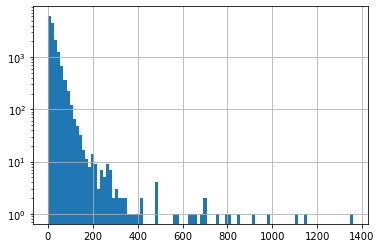

In [18]:
# How many links does every node have?
sm.links[['a', 'b']].stack().value_counts().hist(bins=100, log=True)

In [19]:
# Compute road access and egress links
sm.zone_to_road = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids,
    road.road_nodes,
    short_leg_speed=speed_footpaths,
    long_leg_speed=speed_non_motorised_modes,
    threshold=threshold,
    n_neighbors=20,
    coordinates_unit=sm.coordinates_unit)
sm.zone_to_road = sm.zone_to_road.loc[
    sm.zone_to_road['distance']<=threshold_dict['road']]
len(sm.zone_to_road.index)

18238

In [20]:
sm.zone_to_road = filter_connectors(sm.zone_to_road, keep=1,
                                    length_weight=None,
                                    dist_centr_weight=1)
len(sm.zone_to_road.index)

932

In [21]:
sm.zones.loc[~sm.zones['FID'].isin(list(sm.zone_to_road['a']))]

,CNTR_CODE,NUTS_NAME,LEVL_CODE,FID,NUTS_ID,population,area,urbanisation,lau_id,geometry
index,,,,,,,,,,
DEF07_2,DE,Nordfriesland 2,3,DEF07_2,DEF07,18317,100.145861,3.0,1054,"POLYGON ((8.57200 54.88428, 8.56424 54.88393, ..."


In [22]:
# Compute road - PT links
sm.road_to_transit = engine.ntlegs_from_centroids_and_nodes(
    sm.nodes,
    road.road_nodes,
    short_leg_speed=speed_footpaths,
    long_leg_speed=speed_non_motorised_modes,
    threshold=threshold,
    n_neighbors=1,
    coordinates_unit=sm.coordinates_unit)
sm.road_to_transit = sm.road_to_transit.loc[
    sm.road_to_transit['distance']<=threshold_dict['road_pt']]
len(sm.road_to_transit.index)

16072

In [23]:
# Every route type is saved once in this attribute
assert len(sm.pt_route_types) == len(sm.links['route_type'].unique())
sm.pt_route_types

['rail_long_distance', 'rail_short_distance', 'coach', 'air']

In [24]:
# How many links does every node have?
n_links_dict = sm.links[['a', 'b']].append(bus.links[['a', 'b']]).append(
    sm.footpaths[['a', 'b']]).stack().value_counts().to_dict()

In [25]:
# Compute PT access and egress links by route type
sm.zone_to_transit = sm.zone_to_transit.iloc[0:0]
for t in sm.pt_route_types:
    ntlegs = engine.ntlegs_from_centroids_and_nodes(
        sm.centroids,
        sm.nodes.loc[sm.nodes['route_type']==t],
        short_leg_speed=speed_footpaths,
        long_leg_speed=speed_car, # Take the car for longer trips
        threshold=threshold,
        n_neighbors=5,
        coordinates_unit=sm.coordinates_unit)
    # Cut off long links
    ntlegs = ntlegs.loc[ntlegs['distance']<=
                        threshold_dict['pt']]
    ntlegs['route_type'] = t
    sm.zone_to_transit = sm.zone_to_transit.append(filter_connectors(
        ntlegs, keep=2, length_weight=1, dist_centr_weight=2,
        conn_weight=.4, conn_dict=n_links_dict)).append(filter_connectors(
            ntlegs, keep=2, length_weight=1, conn_weight=1, conn_dict=n_links_dict))
sm.zone_to_transit.reset_index(drop=True, inplace=True)
len(sm.zone_to_transit.index)

6688

In [26]:
# Add bus connections
ntlegs = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids,
    bus.nodes,
    short_leg_speed=speed_footpaths,
    long_leg_speed=speed_car, # Take the car for longer trips
    threshold=threshold,
    n_neighbors=5, # Generate a bunch and clean later
    coordinates_unit=sm.coordinates_unit)
# Cut off long links
ntlegs = ntlegs.loc[ntlegs['distance']<=
                    threshold_dict['pt']]
ntlegs['route_type'] = 'bus'
len(ntlegs.index)

4656

In [27]:
sm.zone_to_transit = sm.zone_to_transit.append(filter_connectors(
    ntlegs, keep=1, length_weight=1, dist_centr_weight=2,
    conn_weight=.4, conn_dict=n_links_dict)).append(filter_connectors(
        ntlegs, keep=1, length_weight=1, conn_weight=1, conn_dict=n_links_dict))
sm.zone_to_transit.reset_index(drop=True, inplace=True)
len(sm.zone_to_transit.index)

8556

In [28]:
sm.zone_to_transit.drop_duplicates(['a', 'b', 'direction'], inplace=True)
sm.zone_to_transit.reset_index(drop=True, inplace=True)
len(sm.zone_to_transit.index)

5374

In [29]:
# Number of legs by route type
sm.zone_to_transit.groupby(['route_type', 'direction'])['a'].count()

route_type           direction
air                  access         27
                     eggress        27
bus                  access        788
                     eggress       549
coach                access        363
                     eggress       353
rail_long_distance   access        450
                     eggress       436
rail_short_distance  access       1272
                     eggress      1109
Name: a, dtype: int64

In [30]:
# Every zone must have an access and an egress link to PT
#sm.zones.loc[sm.zones['FID'].isin(list(sm.zone_to_transit['a']))==False]
assert sm.zones['FID'].isin(list(sm.zone_to_transit['a'])).all()
assert sm.zones['FID'].isin(list(sm.zone_to_transit['b'])).all()

### Parametrise access and egress links

In [31]:
# Road - PT connectors
sm.road_to_transit['distance'] = 0
sm.road_to_transit['time'] = 5*60 # in seconds
sm.road_to_transit.sample(n=2)

,a,b,direction,distance,geometry,rank,speed_factor,short_leg_speed,long_leg_speed,speed,time
17661,268982470,rail_long_node_815,eggress,0,"LINESTRING (6.851588 51.474876, 6.8523855 51.4...",0,0.620690,5,17,5.0,300
26907,63567405,rail_short_node_547,eggress,0,"LINESTRING (10.025285 47.554207, 10.0263427 47...",0,0.732375,5,17,5.0,300


In [32]:
# Road - centroid connectors
sm.zone_to_road['distance'] = 0
sm.zone_to_road['time'] = 0
sm.zone_to_road.sample(n=2)

,a,b,direction,distance,geometry,rank,speed_factor,short_leg_speed,long_leg_speed,speed,time
320,DEA36_1,2084165418,access,0,LINESTRING (7.055043087763056 51.7010932587441...,7,2.367960,5,17,11.839799,0
409,DEA23,743306224,access,0,LINESTRING (6.973153341243033 50.9457064599987...,3,1.187027,5,17,5.935135,0


In [33]:
# Load distances to PT stops from census data
clusters = pd.read_csv('../input/spatial_census_refined_FID.csv')
clusters.set_index('index', inplace=True)
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
#pop_col = 'population'
node_col = 'node_id'

In [34]:
clusters['NUTS_ID'] = clusters['FID'].apply(lambda s: str(s).split('_')[0])

In [35]:
# Create a zone - distance - type dict
# Take the mean weighted distance, assume population shares are about equal
zone_type_dist = clusters.groupby(['NUTS_ID', 'route_type']).agg(
    {mean_dist_col: 'mean'})#.to_dict()[mean_dist_col]
zone_type_dist

mean_weighted_dist
NUTS_ID route_type                             
DE111   bus                         7534.073525
        coach                       8431.291442
        rail_long_distance         10573.888593
        rail_short_distance        15243.095365
DE112   bus                        26148.499516
...                                         ...
DEG0N   coach                       5397.254430
        rail_long_distance          4194.575713
        rail_short_distance         5539.621888
DEG0P   bus                        10844.458205
        rail_short_distance        23040.377472

[1248 rows x 1 columns]

In [36]:
# Split legs into access and egress
access = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access'].copy()
egress = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='eggress'].copy()# name in quetzal

In [37]:
# Alter the distance
route_types = clusters['route_type'].unique()
for t in route_types:
    for zone in list(sm.zones['NUTS_ID']):
        try:
            access.loc[(access['route_type']==t) & (access['a']==zone),
                       'distance'] = zone_type_dist.loc[(zone, t), mean_dist_col]
        except KeyError:
            # There is no such station in this zone
            access.loc[(access['route_type']==t) & (access['a']==zone),
                       'distance'] = np.nan
for t in route_types:
    for zone in list(sm.zones['NUTS_ID']):
        try:
            egress.loc[(egress['route_type']==t) & (egress['b']==zone),
                       'distance'] = zone_type_dist.loc[(zone, t), mean_dist_col]
        except KeyError:
            # There is no such station in this zone
            egress.loc[(egress['route_type']==t) & (egress['b']==zone),
                       'distance'] = np.nan

In [38]:
sm.zone_to_transit = access.append(egress)

In [39]:
len(sm.zone_to_transit.loc[sm.zone_to_transit['distance'].isna()])

112

<AxesSubplot:>

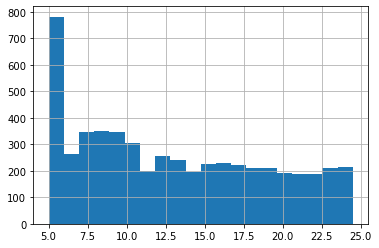

In [40]:
sm.zone_to_transit['speed'].hist(bins=20)

In [41]:
# Correct the speed by linear interpolation
sm.zone_to_transit['speed'] = sm.zone_to_transit['distance'].apply(
    lambda d: (d-threshold)/1000 * \
        ((speed_car-speed_footpaths) / ((threshold_dict['pt']-threshold)/1000))
).clip(lower=speed_footpaths, upper=speed_car)

In [42]:
# Alter time of PT legs
sm.zone_to_transit['time'] = sm.zone_to_transit['distance'] / \
    sm.zone_to_transit['speed'] * 3.6 # in s
sm.zone_to_transit['time'].replace({np.nan: threshold_dict['pt']/speed_car}, inplace=True)

In [43]:
sm.zone_to_transit.loc[sm.zone_to_transit['distance'].isna(), 'distance'] = 0

In [44]:
sm.zone_to_transit.loc[sm.zone_to_transit['speed'].isna(), 'speed'] = 0

In [45]:
print(len(sm.zone_to_transit))
sm.zone_to_transit.sample()

5374


,a,b,direction,distance,geometry,long_leg_speed,rank,route_type,short_leg_speed,speed,speed_factor,time
4496,DE71C,bus_n_327704,access,20364.128034,"LINESTRING (8.81146 50.02168, 8.80368 50.02111)",50.0,0.0,bus,5.0,50.0,1.057838,1466.217218


<AxesSubplot:>

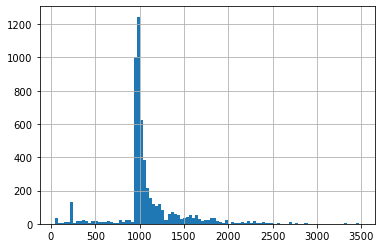

In [46]:
sm.zone_to_transit['time'].hist(bins=100)

In [47]:
# Ditch all legs which take too long
sm.zone_to_transit = sm.zone_to_transit.loc[sm.zone_to_transit['time']<3600]
len(sm.zone_to_transit)

5374

In [48]:
# Every zone must have an access and an egress link to PT
assert sm.zones['FID'].isin(list(sm.zone_to_transit['a'])).all()
assert sm.zones['FID'].isin(list(sm.zone_to_transit['b'])).all()

In [49]:
# Correct link IDs in zone_to_transit for rail modes
type_dict = {'rail_short_distance': 'rail_short', 'rail_long_distance': 'rail_long'}
sm.zone_to_transit['route_type'].replace(type_dict, inplace=True)
sm.zone_to_transit['a'] = sm.zone_to_transit['a'].apply(lambda n: n.replace('rail_long_node', 'r_l_n'))
sm.zone_to_transit['a'] = sm.zone_to_transit['a'].apply(lambda n: n.replace('rail_short_node', 'r_s_n'))
sm.zone_to_transit['b'] = sm.zone_to_transit['b'].apply(lambda n: n.replace('rail_long_node', 'r_l_n'))
sm.zone_to_transit['b'] = sm.zone_to_transit['b'].apply(lambda n: n.replace('rail_short_node', 'r_s_n'))

## Save model

In [50]:
# Drop unneccessary columns
cols = ['speed_factor', 'short_leg_speed', 'long_leg_speed', 'rank']
sm.footpaths.drop(cols, axis=1, inplace=True, errors='ignore')
sm.zone_to_transit.drop(cols, axis=1, inplace=True, errors='ignore')
sm.zone_to_road.drop(cols, axis=1, inplace=True, errors='ignore')
sm.road_to_transit.drop(cols, axis=1, inplace=True, errors='ignore')
sm.zone_to_transit.drop(['n_links'], axis=1, inplace=True, errors='ignore')

In [51]:
# Make tables lighter
cols = ['distance', 'speed', 'time']
sm.footpaths[cols] = sm.footpaths[cols].astype(int)
sm.zone_to_transit[cols] = sm.zone_to_transit[cols].astype(int)

In [52]:
sm.zone_to_road[cols] = sm.zone_to_road[cols].astype(int)
sm.road_to_transit[cols] = sm.road_to_transit[cols].astype(int)

In [53]:
sm.footpaths.sample()

,a,b,direction,distance,geometry,speed,time
foot_1760,rail_short_node_2545,rail_long_node_383,access,0,"LINESTRING (8.77279 47.85635, 8.77279 47.85635)",5,0


In [54]:
# Saving model...
tables = ['centroids', 'footpaths', 'zone_to_transit']
sm.to_json(model_path + 'de_pt_access_egress',
           only_attributes=tables, encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 37/37 [00:07<00:00,  4.83it/s]


In [55]:
sm.to_json(model_path + 'de_road_access_egress',
           only_attributes=['centroids', 'zone_to_road', 'road_to_transit'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 37/37 [00:03<00:00, 11.15it/s]
